In [1]:
import pandas as pd
import numpy as np
import os.path as osp
import seaborn
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Perceptron

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Pr1_data/problem1_data.csv') 
data = data.sample(frac=1)

100%|██████████| 1000/1000 [01:30<00:00, 11.01it/s]


Mean Training Error: 0.16% | Mean Test Error: 0.17%


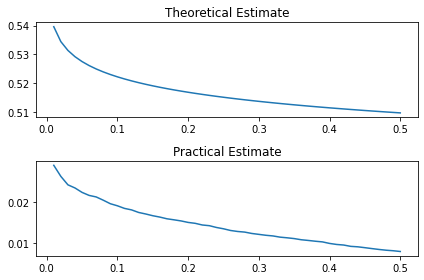

In [11]:
def tolerance_study(runs,N_in):
  errors = {
      'train': [],
      'test': [],
      "epsilon" : []
  } 

  X = data[['feat_0','feat_1','feat_2']]
  y = data[['class']] 

  din_end = np.power(10,6) - np.power(10,5)
  X_tr , y_tr = np.array(X.iloc[din_end:, :]), np.array(y.iloc[din_end:, :]).ravel()
  X_te, y_te =  np.array(X.iloc[:din_end, :]), np.array(y.iloc[:din_end]).ravel()
  dummy1, X_test, dummy2, y_test = train_test_split(X_te, y_te, test_size=np.power(10,5), stratify=y_te)

  for i in tqdm(range(runs)):
    X_train, dummy1, y_train, dummy2 = train_test_split(X_tr, y_tr, train_size=N_in, stratify=y_tr)
    clf = Perceptron(n_jobs=-1)
    clf.fit(X_train, y_train)

    y_pred_train = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    
    E_in = np.mean(y_pred_train != y_train)
    E_out = np.mean(y_pred != y_test)

    diff = np.absolute(E_out-E_in)

    errors["train"].append(E_in)
    errors["test"].append(E_out)
    errors["epsilon"].append(diff)

  print(f'Mean Training Error: {(np.mean(errors["train"])):.2f}% | Mean Test Error: {(np.mean(errors["test"])):.2f}%')
  
  ep = np.sort(np.array(errors['epsilon']))[::-1]
  total = np.shape(ep)[0]

  estimates = {
    'delta': [],
    'theoretical' : [],
    'experimental' : []
  }

  def theoretical_estimate():
    N = N_in
    d_vc = 4
    M = 1
    for delta in np.arange(0.01,0.51,1e-2):
      estimates['delta'].append(delta)
      gen_error = np.sqrt((8/N)*np.log(4*(np.power(2*N,d_vc)+1)/delta))
      # gen_error = np.sqrt((1/2*N)*np.log(2*M/delta))
      estimates['theoretical'].append(gen_error)
  theoretical_estimate()

  for delta in np.arange(0.01, 0.51,1e-2):
    proportion_delta_samples = np.int(delta * total)
    estimates['experimental'].append(ep[proportion_delta_samples])
    # print(f'Delta: {np.round(delta,2):.2f} Max Epsilon: {ep[proportion_delta_samples]:.4f}')

  plt.subplot(2, 1, 1) 
  plt.plot(estimates['delta'], estimates['theoretical']) 
  plt.title('Theoretical Estimate')  

  plt.subplot(2, 1, 2) 
  plt.plot(estimates['delta'], estimates['experimental']) 
  plt.title('Practical Estimate')  

  plt.tight_layout() 
  plt.show()

tolerance_study(1000,1000)

Would you say the theoretical bound is tight, moderate, or loose in this
experiment? (Let’s define tight as within a factor of 2; moderate as a factor of
2-10; and loose as a factor of more than 10.) Would you say the relationship
between the bound and the tolerance level is the same in theory and in the
experiment, i.e., do the plots have similar shapes? If not, conjecture why if
you can.

Ans: The theoretical bound is loose as it is more than a factor of 10 as compared to practical bound. The plots do have similar shapes.

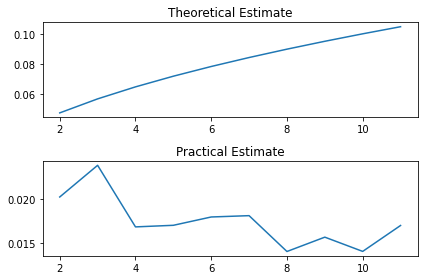

In [7]:
def vcd_study(N_in):
  delta = 0.1
  
  d_vcs = [i for i in range(2,12)]

  theoretical = {
      'd_vcs' : [],
      'theoretical' :[]
  }
  def theoretical_estimate():
    N = np.power(10,5)
    delta = 0.1
    M = 1
    for dvc in d_vcs:
      theoretical['d_vcs'].append(dvc)
      gen_error = np.sqrt((8/N)*np.log(4*(np.power(2*N,dvc, 
                                                   dtype=np.float64)+1)/delta, 
                                                   dtype=np.float64), dtype=np.float64)
      theoretical['theoretical'].append(gen_error)
  theoretical_estimate()


  din_end = np.power(10,6) - np.power(10,5)
  X = data.iloc[:,:10]
  y = data[['class']]
  data_train = data.iloc[:din_end,:]
  X_test , y_test = X.iloc[din_end:, :], np.array(y.iloc[din_end:, :]).ravel()

  errors = {i:[] for i in range(2,12)}
  for i in range(100):
    
    d_train = data_train.sample(n=N_in)
    X_train = d_train.iloc[:,:10]
    y_train = np.array(d_train[['class']]).ravel()

    for dvc in d_vcs:
      X_train, X_test = X_train.copy(), X_test.copy()
      X_train_, X_test_ = np.array(X_train)[:,:dvc-1], np.array(X_test)[:,:dvc-1]
      
      clf = Perceptron(n_jobs=-1)
      clf.fit(X_train_, y_train)

      y_pred_train = clf.predict(X_train_)
      y_pred = clf.predict(X_test_)
      
      E_in = np.mean(y_pred_train != y_train)
      E_out = np.mean(y_pred != y_test)
      errors[dvc].append(np.absolute(E_out-E_in))

  dvcs = []
  max_vals = []

  for key, values in errors.items():
    dvcs.append(key)
    values.sort(reverse=True)
    proportion_delta_samples = np.int(delta * 100)
    max_vals.append(values[proportion_delta_samples])

  plt.subplot(2, 1, 1) 
  plt.plot(theoretical['d_vcs'], theoretical['theoretical']) 
  plt.title('Theoretical Estimate')  

  plt.subplot(2, 1, 2) 
  plt.plot(dvcs, max_vals) 
  plt.title('Practical Estimate')  

  plt.tight_layout() 
  plt.show()

vcd_study(1000)

Would you say the theoretical bound is tight, moderate, or loose in this
experiment? (Let’s define tight as within a factor of 2; moderate as a factor of 2-10; and loose as a factor of more than 10.) Would you say the relationship
between the bound and the VC dimension is the same in theory and in the
experiment, i.e., do the plots have similar shapes?

Ans: Theoretical bound is moderate as it is within a factor of 2-10 as compared with practical bound. The plots do not have similar shapes and hence the practical and theoretical relationships are different.

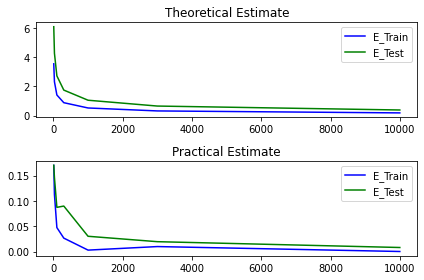

In [9]:
def sample_dependence_study():

  N_train = [10,30,100,300,1000,3000,10000]
  dvc = 4
  delta = 0.1

  theoretical = {
      'n_train' : [],
      'theoretical_train' :[],
      'theoretical_test' : []
  }
  def theoretical_estimate():
    for N in N_train:
      N_test = N / 5
      theoretical['n_train'].append(N)
      theoretical['theoretical_test'].append(
          np.sqrt((8/N_test)*np.log(4*(np.power(2*N_test,dvc)+1)/delta)))
      gen_error = np.sqrt((8/N)*np.log(4*(np.power(2*N,dvc, 
                                                   dtype=np.float64)+1)/delta, 
                                                   dtype=np.float64), dtype=np.float64)
      theoretical['theoretical_train'].append(gen_error)
  theoretical_estimate()

  d_out = data.sample(n=100000)
  X_out = np.array(d_out.iloc[:,:3])
  y_out = np.array(d_out[['class']]).ravel()

  din_end = np.power(10,6) - np.power(10,5)
  X = data.iloc[:,:3]
  y = data[['class']]
  data_train = data.iloc[:din_end,:]
  X_test , y_test = X.iloc[din_end:, :], np.array(y.iloc[din_end:, :]).ravel()

  E_train_errors = {i:[] for i in N_train}
  E_test_errors = {i:[] for i in N_train}

  for N in N_train:

    N_test = int(N / 5)
    d_train = data_train.copy()
    d_train_1 = d_train.sample(n=N).iloc[:N,:]
    X_train = d_train_1.iloc[:,:3]
    y_train = np.array(d_train_1[['class']]).ravel()

    for i in range(100):
      X_train, X_test, y_test = X_train.copy(), X_test.copy(), y_test.copy()
      X_train_, X_test_, y_test_ = np.array(X_train)[:,:], np.array(X_test)[:N_test,:], y_test[:N_test]

      clf = Perceptron(n_jobs=-1)
      clf.fit(X_train_, y_train)

      y_pred_train = clf.predict(X_train_)
      y_pred = clf.predict(X_test_)
      y_pred_d = clf.predict(X_out)
      
      E_train = np.mean(y_pred_train != y_train)
      E_test = np.mean(y_pred != y_test_)
      E_out = np.mean(y_pred_d != y_out)
      E_train_errors[N].append(np.absolute(E_out-E_train))
      E_test_errors[N].append(np.absolute(E_out-E_test))

  N_vals = []
  max_train_vals = []
  for key, values in E_train_errors.items():
    N_vals.append(key)
    values.sort(reverse=True)
    proportion_delta_samples = np.int(delta * 100)
    max_train_vals.append(values[proportion_delta_samples])

  max_test_vals = []
  for key, values in E_test_errors.items():
    values.sort(reverse=True)
    proportion_delta_samples = np.int(delta * 100)
    max_test_vals.append(values[proportion_delta_samples])

  plt.subplot(2, 1, 1) 
  plt.plot(theoretical['n_train'], theoretical['theoretical_train'], color='blue', label='E_Train') 
  plt.plot(theoretical['n_train'], theoretical['theoretical_test'], color='green',  label='E_Test') 
  plt.legend(loc="upper right")
  plt.title('Theoretical Estimate')  

  plt.subplot(2, 1, 2)  
  plt.plot(N_vals, max_train_vals, color='blue', label='E_Train')
  plt.plot(N_vals, max_test_vals, color='green', label='E_Test')
  plt.title('Practical Estimate')  
  plt.legend(loc="upper right")
  plt.tight_layout() 
  plt.show()

sample_dependence_study()

Would you say the theoretical bound is tight, moderate, or loose in this
experiment? (Let’s define tight as within a factor of 2; moderate as a factor of 2-10; and loose as a factor of more than 10.) Would you say the relationship
between the bound and the number of training samples is the same in theory and
in the experiment, i.e., do the plots have similar shapes? If not, conjecture why if you can. 

Ans: The theoretical bound is loose as it is greater than practical bound by factor more than 10. However the plots looks similar and we can say practical and theoretical relationships are the same.

100%|██████████| 1000/1000 [01:29<00:00, 11.14it/s]


Mean Training Error: 0.04% | Mean Test Error: 0.19%


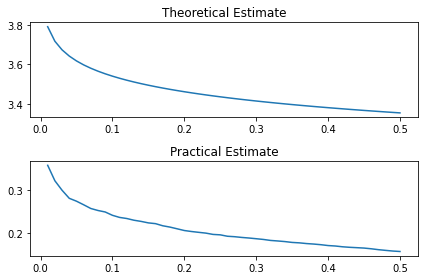

In [12]:
# (d)

tolerance_study(1000,10)

The theoretical bound can be moderate or loose for N_in = 10

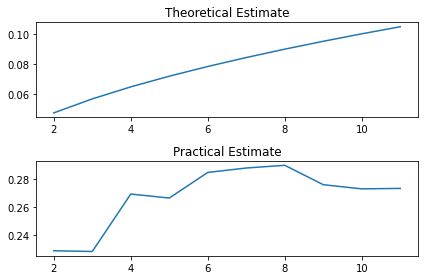

In [13]:
vcd_study(10)

The theoretical bound is moderate for N_in = 10

100%|██████████| 1000/1000 [01:32<00:00, 10.84it/s]


Mean Training Error: 0.15% | Mean Test Error: 0.16%


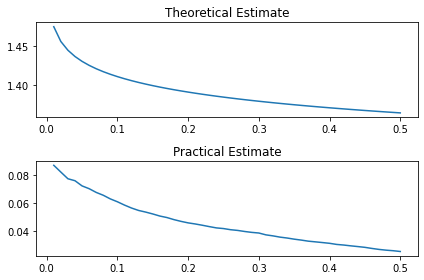

In [14]:
tolerance_study(1000,100)

The theoretical bound is tight for N_in = 100

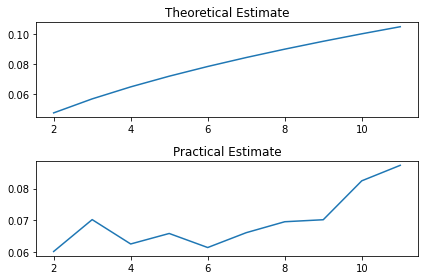

In [15]:
vcd_study(100)

The theoretical bound is tight for N_in = 100